# Classification and Regression Trees

## Monday November 7, 2016



Fill in missing code

### Classification

In [1]:
# Question: How does ROC help you select a threshold? 
# http://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it <- explains ROC brilliantly

# How do you plot threshold coded ROC curves
# http://stackoverflow.com/questions/22518230/creating-a-threshold-coded-roc-plot-in-python

# To understand:
# Learn how to visualise decision trees
# Fit the ROC curve plot to your data

In [2]:
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline

/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### Read, Explore, and Process data

In [3]:
# Read in the data
titanic = pd.read_csv('titanic.csv')

# Take a  selection of the features
d = titanic[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Check for missing values in all columns
d.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
dtype: int64

In [6]:
# Check for missing values in Age column, after grouping by other columns
d.groupby(['Sex', 'Pclass']).Age.apply(lambda x: x.isnull().sum()) / d.groupby(['Sex', 'Pclass']).Age.count()

Sex     Pclass
female  1         0.105882
        2         0.027027
        3         0.411765
male    1         0.207921
        2         0.090909
        3         0.371542
Name: Age, dtype: float64

In [7]:
# Fill in missing values with the mean value (use .fillna())
d['Age'] = d['Age'].fillna(d['Age'].mean())

/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [8]:
# Convert any text categorical features to numeric for scikit learn
d['Sex'] = np.where(d.Sex == 'female', 1, 0)

/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [9]:
# Explore the data to identify trends in characteristics of survivors
d.Survived.value_counts()                    # How many people lived and died
#d.Survived.mean()                            # The survival rate for everyone
#d.groupby('Sex').Survived.mean()             # By Sex: women have higher survival rates
#d.groupby('Pclass').Survived.mean()          # By Pclass: 1st class passengers have higher survival rates
#d.groupby(['Sex', 'Pclass']).Survived.mean() # By Sex and Pclass: Women in the 1st and 2nd classes had the highest survival rates


0    549
1    342
Name: Survived, dtype: int64

In [10]:
1 - float(342)/float(891)

0.6161616161616161

In [11]:
# Create a new feature representing whether the Spouse was on board
d['Spouse'] = ((d.Age > 18) & (d.SibSp >= 1)).astype(int)
d.Spouse.value_counts()
d.groupby(['Pclass', 'Spouse']).Survived.mean() # Having a spouse appears to increase survival in the 1st class only

/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Pclass  Spouse
1       0         0.575342
        1         0.742857
2       0         0.473684
        1         0.470588
3       0         0.240786
        1         0.250000
Name: Survived, dtype: float64

#### Split into training and test datasets, and build the model

In [12]:
survived = d['Survived']
del d['Survived']
d.head()

,Pclass,Sex,Age,SibSp,Parch,Spouse
0,3,0,22.0,1,0,1
1,1,1,38.0,1,0,1
2,3,1,26.0,0,0,0
3,1,1,35.0,1,0,1
4,3,0,35.0,0,0,0


In [13]:
# Now, split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(d,survived, random_state=1)

In [14]:
# Create a decision tree classifier object (start out with a small tree for interpretability)
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# Fit the decision tree classifier
treef = ctree.fit(X_train, y_train) # specifies the whole decision tree, can specify the depth though this default function does it auto

#### Confusion Matrix

In [15]:
# How to interpret the diagram?
ctree.classes_

array([0, 1])

For a plotting function that will plot a nice confusion matrix see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [16]:
# %load confusion_matrix_nice.py
# from confusion_matrix_nice import plot_confusion_matrix
%run confusion_matrix_nice.JL

Confusion matrix, without normalization
[[119   9]
 [ 52  43]]


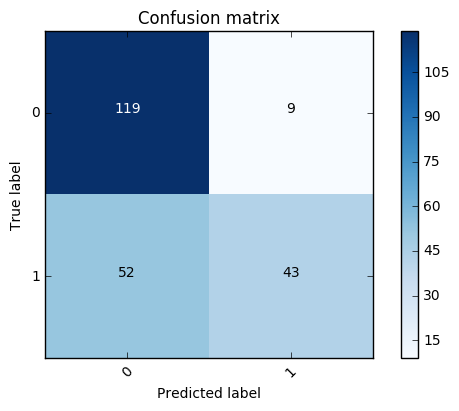

In [17]:
# get the predictions (not the probabilities)
y_pred_class = ctree.predict(X_test)

# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

#### Use the Model

In [18]:
# Create a feature vector for reference. We will create fictional values for test observations. 
features = X_train.columns.tolist()
features

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Spouse']

In [19]:
# Predict what will happen for 1st class woman
#features
ctree.predict_proba([1, 1, 25, 0, 0, 0])
#ctree.predict([1, 1, 25, 0, 0, 0])


/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.05555556,  0.94444444]])

In [20]:

# Predict what will happen for a 3rd class man
ctree.predict_proba([3, 0, 25, 0, 0, 0])
#ctree.predict([3, 0, 25, 0, 0, 0])


/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.85714286,  0.14285714]])

#### Evaluate

In [37]:
# Which features are the most important? - sex
ctree.feature_importances_

# Make a Dataframe out of the features and the importance measure for the features
pd.DataFrame(zip(features, ctree.feature_importances_)).sort_index(by=1, ascending=False)

# Make predictions on the test set
#preds = ctree.predict(X_test) #same as y_pred_class

# Calculate accuracy
#metrics.accuracy_score(y_test, preds)

# Confusion matrix (in a table)
#pd.crosstab(y_test, preds, rownames=['actual'], colnames=['predicted'])

# Make predictions on the test set using predict_proba; returns a list of predicted probabilities for the test set
#probs = ctree.predict_proba(X_test)[:,1]

# Calculate the AUC metric
#metrics.roc_auc_score(y_test, probs)


# Decision Trees have notorouisly high variance, so what can we do
# to better estimate the out of sample error of a high variance model?



NotFittedError: Estimator not fitted, call `fit` before `feature_importances_`.

##### Compare against Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# compare AUC using cross-validation
from sklearn.cross_validation import cross_val_score
print cross_val_score(logreg, d, survived, cv=10, scoring='roc_auc').mean() #auc:area under the curve
print cross_val_score(ctree, d, survived, cv=10, scoring='roc_auc').mean()

# so far logistic regression is winning..


0.853902342755
0.801835851512


In [23]:
# plotting ROC
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Module created for script run in IPython


In [24]:
# import some data to play with
X = d
y = survived
X, y = X[y != 2], y[y != 2] # why?
n_samples, n_features = X.shape
 
# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

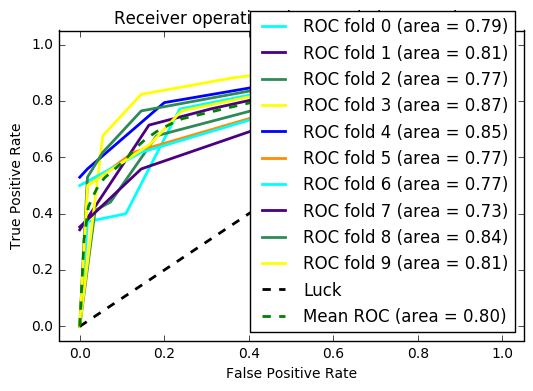

In [26]:
# Run classifier with cross-validation and plot ROC curves
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# Action: Need to check if this code exactly replicates the output from earlier

cv = StratifiedKFold(n_splits=10) 

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

# Plotting ROC curves based on each test sample
i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = ctree.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

# Plotting linear ROC line
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

# Plotting mean ROC curve
mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

# Defining plot parameters
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##### FINE-TUNING THE TREE

In [30]:
from sklearn.grid_search import GridSearchCV

# CV: cross validation
# check CV score for max depth = 3
ctree = tree.DecisionTreeClassifier(max_depth=3)
print np.mean(cross_val_score(ctree, d, survived, cv=5, scoring='roc_auc'))

# check CV score for max depth = 10
ctree = tree.DecisionTreeClassifier(max_depth=10)
print np.mean(cross_val_score(ctree, d, survived, cv=5, scoring='roc_auc'))

0.837955748859
0.809674609845


In [31]:
# Conduct a grid search for the best tree depth
ctree = tree.DecisionTreeClassifier(random_state=1)
depth_range = range(1, 20)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5, scoring='roc_auc')
grid.fit(d, survived)



GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

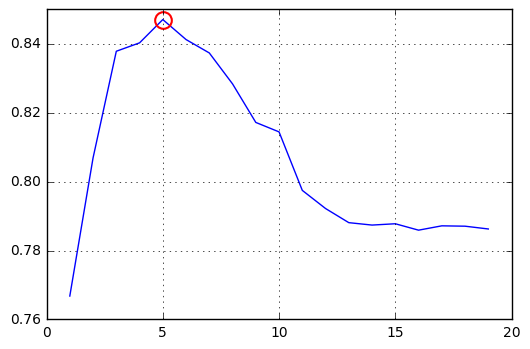

In [32]:
# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]


# Plot the results of the grid search
plt.figure()
plt.plot(depth_range, grid_mean_scores)
plt.hold(True)
plt.grid(True)
plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

# ROC is maximised when the tree depth is 5

In [36]:

# Get the best estimator
best = grid.best_estimator_

print cross_val_score(best, d, survived, cv=10, scoring='roc_auc').mean()
print cross_val_score(logreg, d, survived, cv=10, scoring='roc_auc').mean()


# Still not as good as Logistic Regression.. 
# Let's try something else

### EXERCISE ###
#''' Use Grid Search try scan over three parameters
#1. max_depth:     from 1 to 20
#2. criterion:     (either 'gini' or 'entropy')
#3. max_features : range (1,5)

ctree = tree.DecisionTreeClassifier(random_state=1)
depth_range = range(1, 20)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5, scoring='roc_auc')
grid.fit(d, survived)

#'''


0.847304119628
0.853902342755


### Regression

In [ ]:
# Decision trees (like many other classification models)
# can also be used for regression!


drinks = pd.read_csv('drinks.csv', na_filter=False)

drinks

# Make dummy columns for each of the 6 regions
for continent_ in ['AS', 'NA', 'EU', 'AF', 'SA', 'OC']:
    drinks[continent_] = drinks['continent'] == continent_

drinks


del drinks['continent']
del drinks['country']
del drinks['total_litres_of_pure_alcohol'] # this doesn't seem fair does it?

X = drinks.drop('wine_servings', axis=1)
y = drinks['wine_servings']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)


rtree = tree.DecisionTreeRegressor()

rtree.fit(X_train, y_train)
rtree.predict(X_test)

scores = - cross_val_score(rtree, X, y, cv=10, scoring='neg_mean_squared_error')
mse_scores = scores
mse_scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores
rmse_scores.mean()

wine_mean = y.mean()
wine_mean

features = X.columns
pd.DataFrame(zip(features, rtree.feature_importances_)).sort_values(by=1, ascending=False)

